In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from preprocess import load_clean_data, data_stats, create_features, create_features_labels
from plots import plot_validation_diagram, plot_samples, plot_avg, plot_ewma, detect_raw_signal, plot_validation_diagrams
from IPython.display import display
from keras.models import load_model
from evaluate import evaluate_ae_models, evaluate_seq_models, evaluate_dummy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load whole dataset

In [2]:
data = load_clean_data(range(48))

Error while parsing file inxed=2 , [Errno 2] No such file or directory: 'dataset/2.ann.gz'
Error while parsing file inxed=4 , [Errno 2] No such file or directory: 'dataset/4.ann.gz'
Error while parsing file inxed=44 , [Errno 2] No such file or directory: 'dataset/44.ann.gz'


### Show beat types distribution

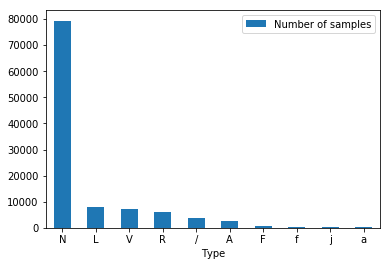

In [3]:
df = data_stats(data)
type_occ = pd.DataFrame(df.sum().sort_values(ascending=False).head(10), columns=['Number of samples'])
type_occ.index.name = 'Type'
type_occ.plot(kind='bar', rot=0);

In [4]:
df

,?,/,a,A,B,e,E,f,F,j,J,L,n,N,Q,r,R,S,V
0,0,0,0,33,0,0,0,0,0,0,0,0,0,2239,0,0,0,0,1
1,0,0,0,3,0,0,0,0,0,0,0,0,0,1860,2,0,0,0,0
2,0,0,0,3,0,0,0,0,0,0,0,0,0,1860,2,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,0,0,0,2082,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,0,0,0,2082,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,2526,5,0,0,0,41
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1507,0,0,0,0,520
7,0,2078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59
8,0,0,0,4,0,0,0,0,2,1,0,0,0,1739,0,0,0,0,17
9,0,0,0,0,0,0,0,0,2,0,0,2492,0,0,0,0,0,0,38


### Show number of 'A' beat per patient

In [5]:
sorted_a = df[['A', 'N', 'V', 'L', 'R']].sort_values(by='A', ascending=False)

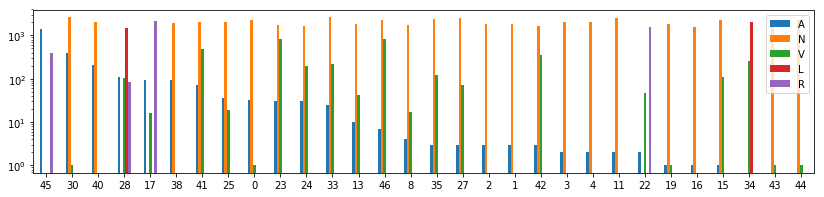

In [6]:
sorted_a[0:30].plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

### Split data into train and test set

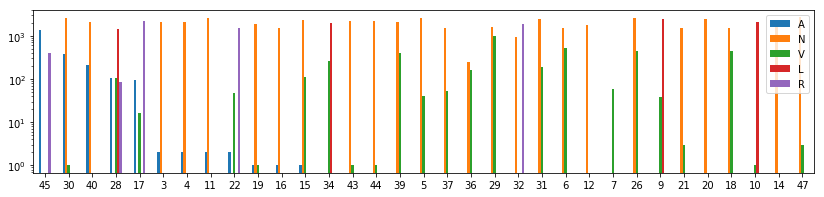

In [7]:
data_index = pd.concat([sorted_a[0:5],sorted_a[20:]])
data_index.head(10)
data_index.plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

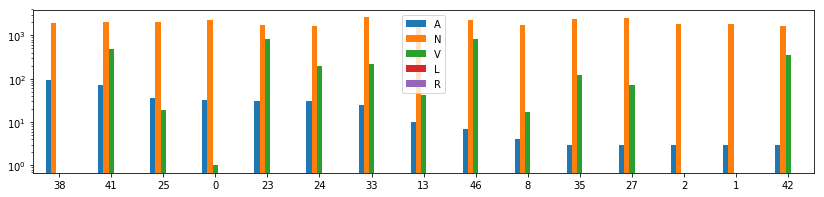

In [8]:
val_index = sorted_a[5:20]
val_index.plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

In [12]:
data_index.index, val_index.index

(Int64Index([45, 30, 40, 28, 17,  3,  4, 11, 19, 16, 15, 34, 43, 44, 39,  5, 37,
             36, 29, 31,  6, 12, 26, 21, 20, 18, 14, 47],
            dtype='int64'),
 Int64Index([38, 41, 25, 0, 23, 24, 33, 13, 46, 8, 35, 27, 2, 1, 42, 7, 9, 10,
             22, 32],
            dtype='int64'))

In [10]:
val_index = val_index.append(data_index.loc[7])
val_index = val_index.append(data_index.loc[9])
val_index = val_index.append(data_index.loc[10])
val_index = val_index.append(data_index.loc[22])
val_index = val_index.append(data_index.loc[32])

In [11]:
data_index.drop([9, 10, 22, 32, 7], inplace=True)

In [ ]:
L 28, 34 -> t, 9,10,  > v

In [ ]:
R 17,  45 > t , 22, 32, > v

In [ ]:
/ 36 -> t, 7 > v

### Check if the dataset do not intersect

In [107]:
set_d, set_v = set(data_index.index.values), set(val_index.index.values)

In [108]:
set_d.intersection(set_v)

set()

In [13]:
train = data[data_index.index.values]
validation = data[val_index.index.values]

### Investigate sample signals

In [14]:
#plot_samples(train[-10:-5])

### Create small train/test set

In [14]:
lb = LabelBinarizer()
non_beats, beat_types = 1, ['A', 'N', 'V', 'L', 'R']
x_train_all, labels = create_features_labels(data, 784, non_beats_per_beat = non_beats, beat_types=beat_types)
y_train_all = lb.fit_transform(labels)

x_test_all, labels = create_features_labels(validation, 784, non_beats_per_beat = non_beats, beat_types=beat_types)
y_test_all = lb.transform(labels)

In [15]:
x_train_all.shape, x_test_all.shape

((205854, 784), (86010, 784))

In [16]:
df = pd.DataFrame(np.c_[np.sum(y_train_all, axis = 0), np.sum(y_test_all, axis = 0)], index = lb.classes_, columns = ['Train', 'Validation'])
df.index.name = 'Beat type'
display(df)

,Train,Validation
Beat type,,
A,2542,358
L,8065,4609
N,79257,31359
NB,102927,43005
R,5998,3353
V,7065,3326


In [17]:
x_train, _, y_train, _ = train_test_split(x_train_all, y_train_all, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test_all, y_test_all, test_size = .9)

In [18]:
x_train.shape, x_test.shape

((20585, 784), (8601, 784))

In [19]:
pd.DataFrame(np.c_[np.sum(y_train, axis = 0), np.sum(y_test, axis = 0)], index = lb.classes_, columns = ['Train', 'Test'])

,Train,Test
A,255,40
L,777,440
N,7951,3145
NB,10310,4301
R,594,349
V,698,326


In [20]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [37]:
ann[ann['Type'] == 'A'][:10]

,Time,Sample,Type
60,0:49.822,17936,A
376,5:18.703,114733,A
381,5:22.600,116136,A
395,5:34.283,120342,A
472,6:41.181,144425,A
483,6:48.508,147063,A
485,6:49.103,147277,A
486,6:49.544,147436,A
491,6:51.872,148274,A
492,6:52.289,148424,A


### Check NN autoencoder

Running autoencoder with config: [784, [], 128]


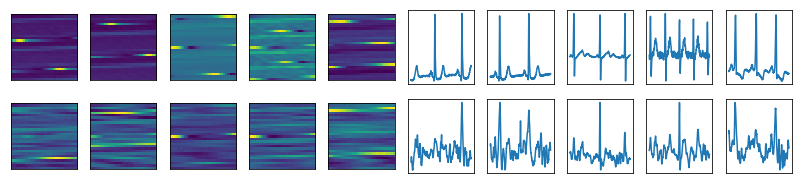

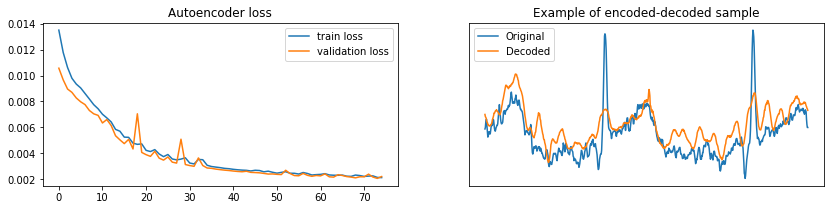

Evaluating model with fc: [3]


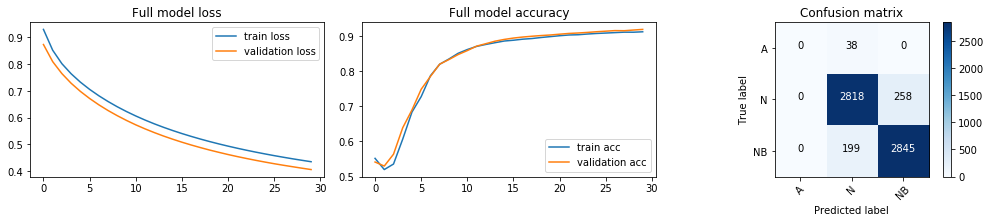

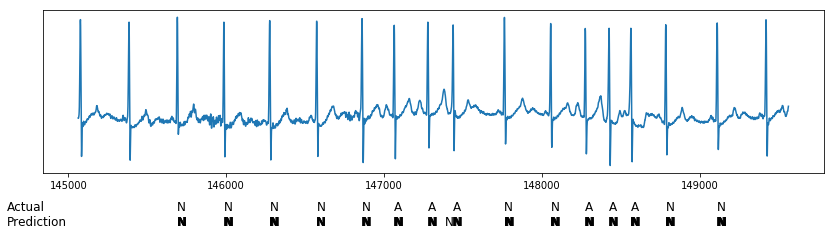

/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Evaluating model with fc: [64, 3]


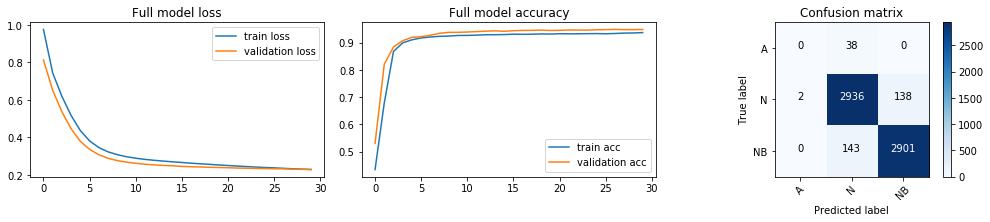

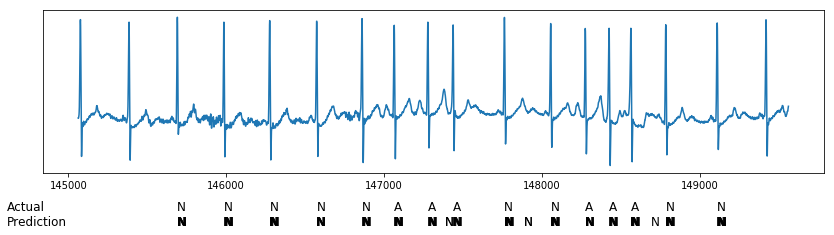

Evaluating model with fc: [128, 3]


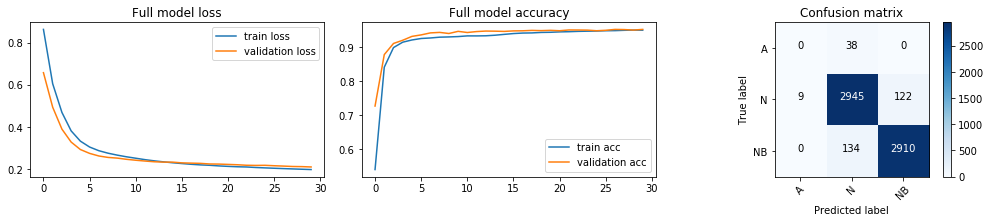

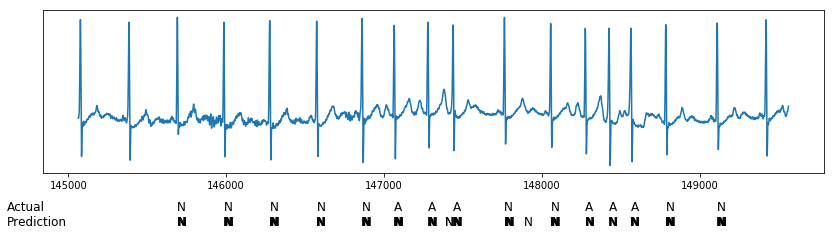

Running autoencoder with config: [784, [256, 128], 64]


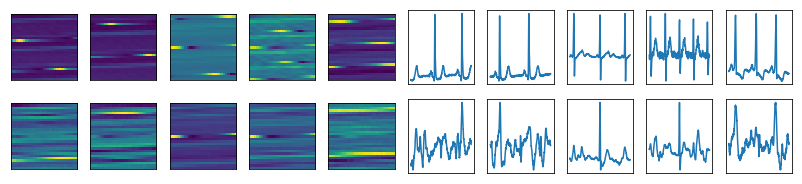

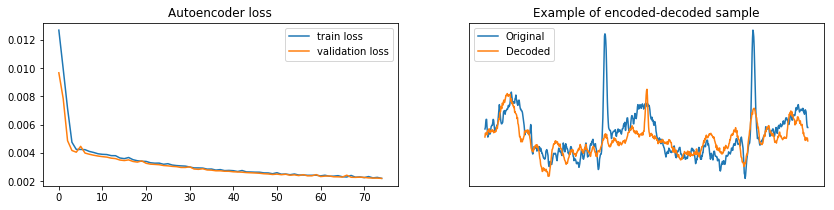

Evaluating model with fc: [3]


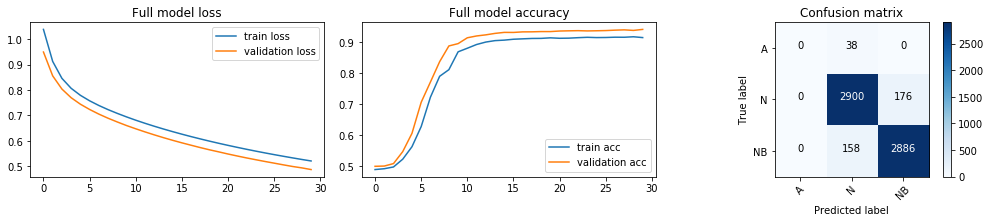

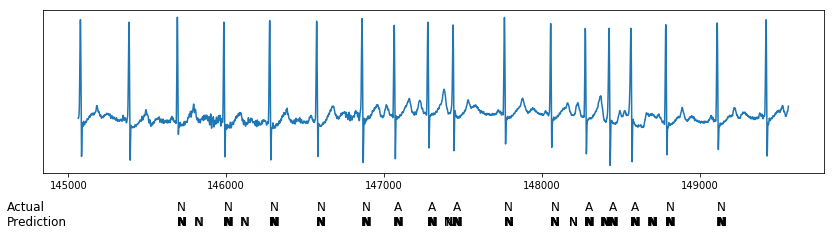

Evaluating model with fc: [64, 3]


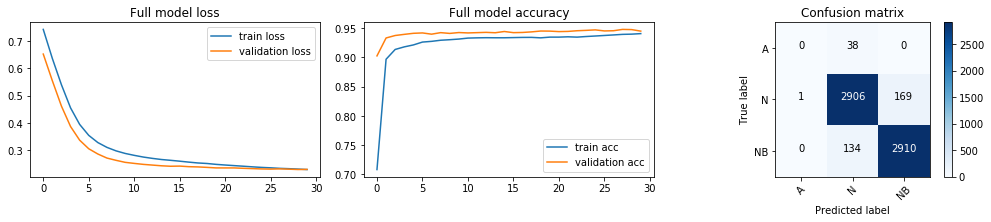

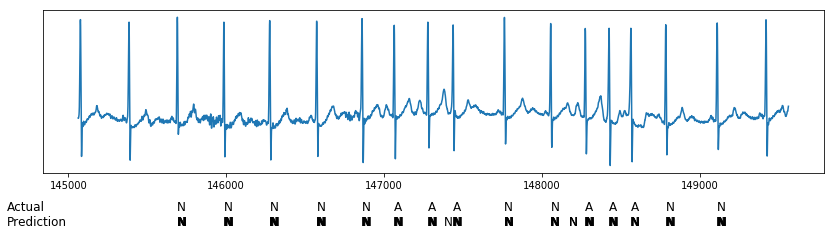

Evaluating model with fc: [128, 3]


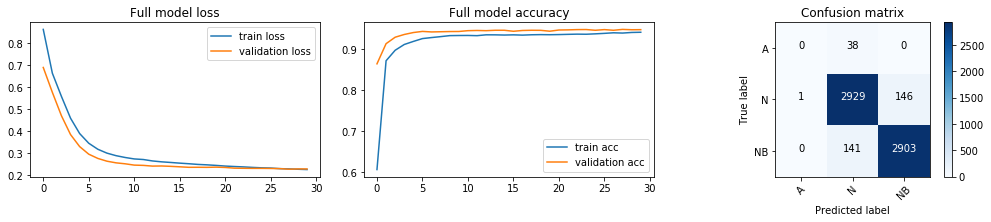

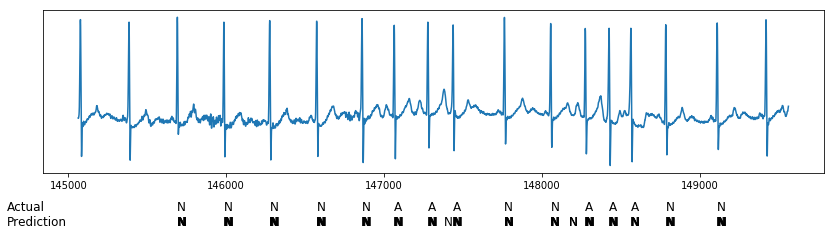

In [218]:
config = {
    'use_conv': False,
    'ae' : [ [784,[], 128] ],
    'fc' : [ [3] ]
#     'ae' : [ [784,[], 128], [784, [256, 128], 64]],
#     'fc' : [ [3], [64,3], [128, 3]]

}
nn_models = evaluate_ae_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                               ae_epochs=75, full_model_epochs=30, load_prev_ae=False, load_prev_full=False)

### Check CONV autoencoder

Running autoencoder with config: [(28, 28), [16, 8, 8], (4, 4)]


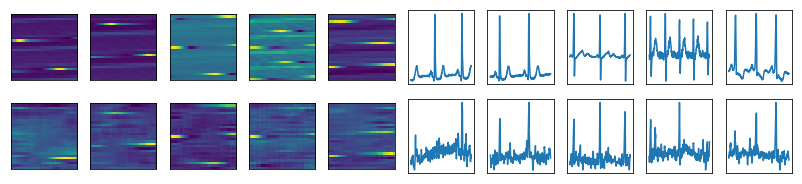

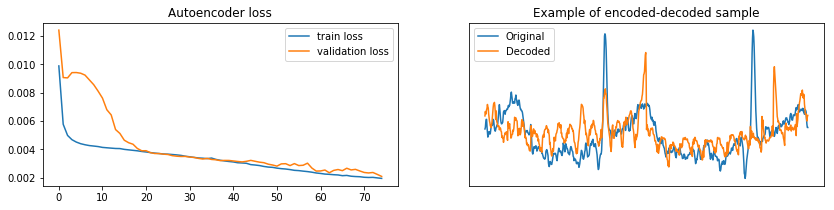

Evaluating model with fc: [3]


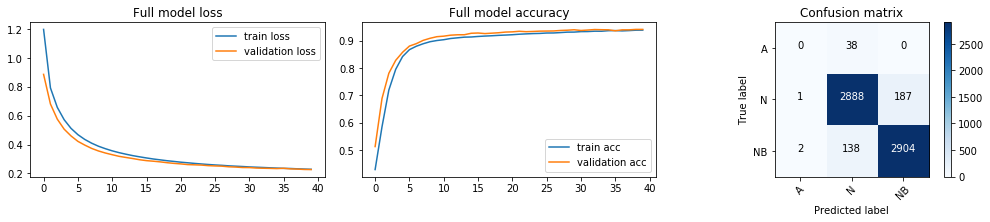

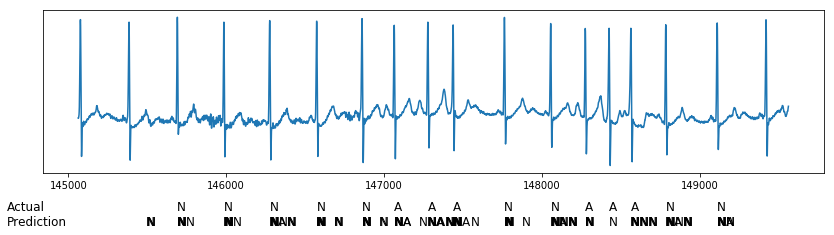

Evaluating model with fc: [64, 3]


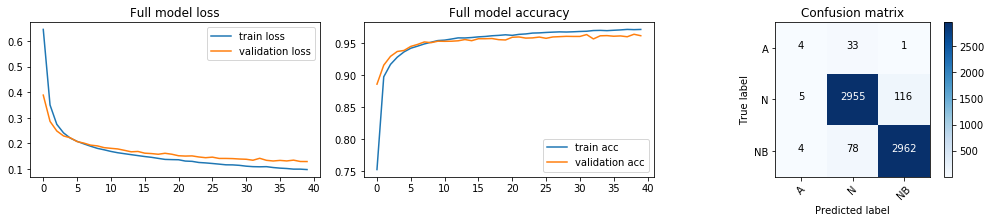

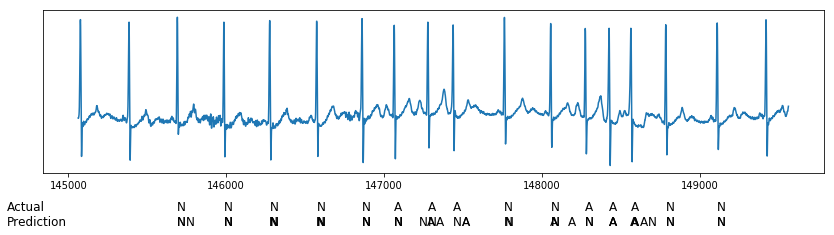

Evaluating model with fc: [128, 3]


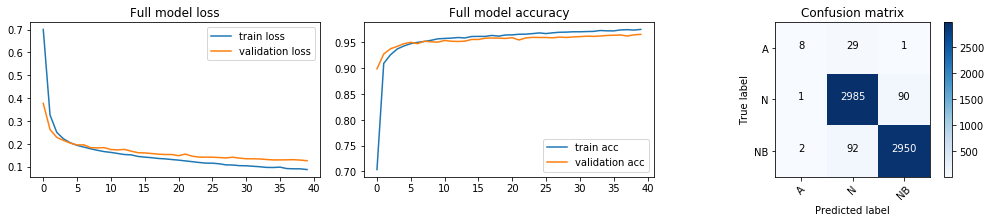

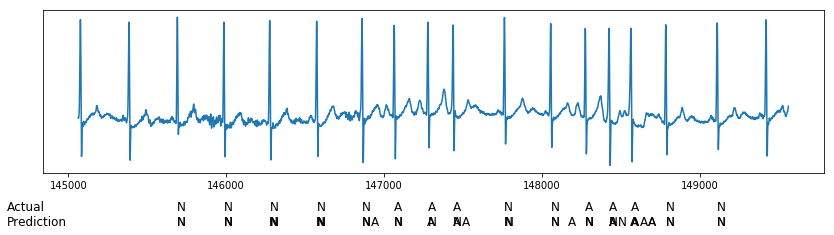

Evaluating model with fc: [1024, 3]


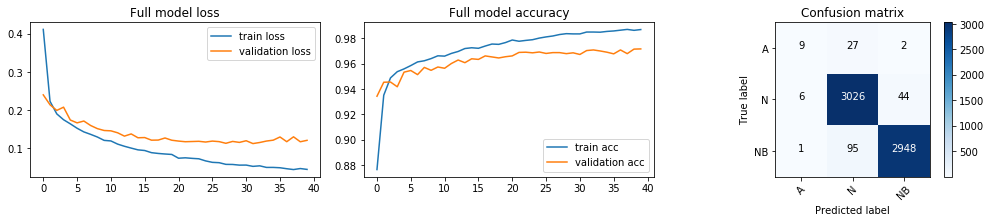

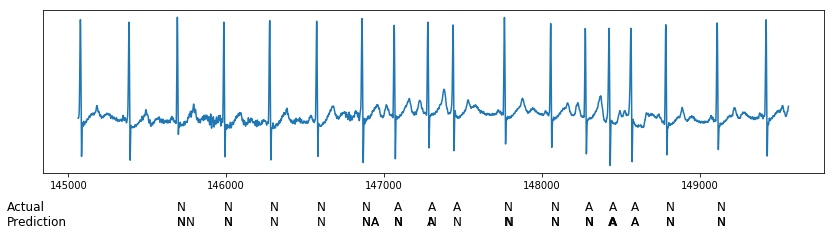

Running autoencoder with config: [(28, 28), [32, 16, 16], (4, 4)]


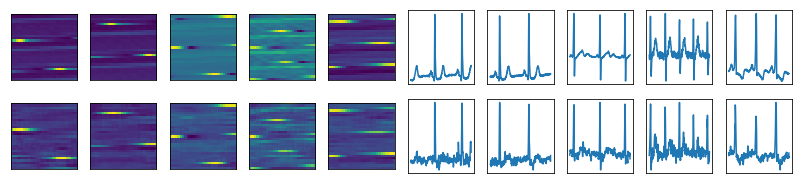

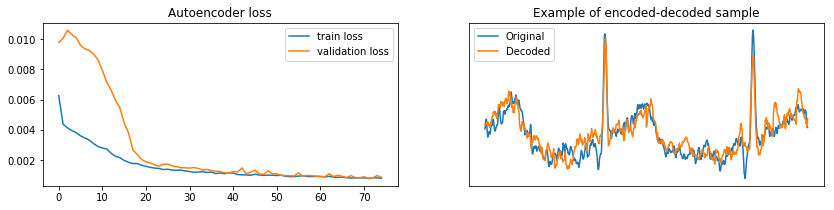

Evaluating model with fc: [3]


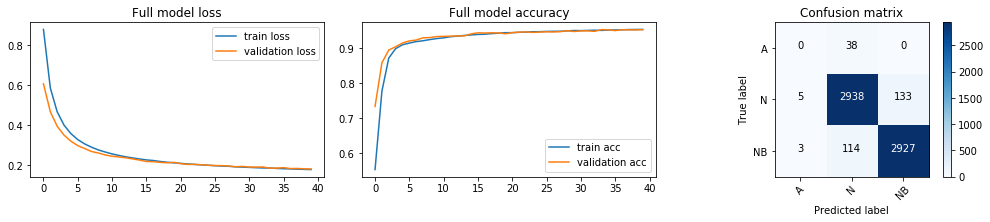

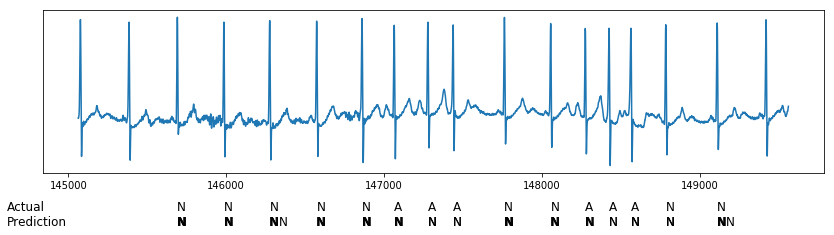

Evaluating model with fc: [64, 3]


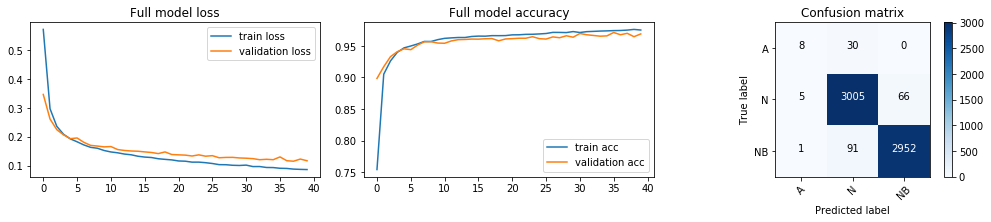

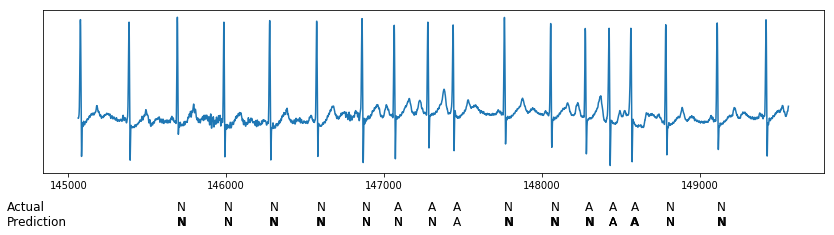

Evaluating model with fc: [128, 3]


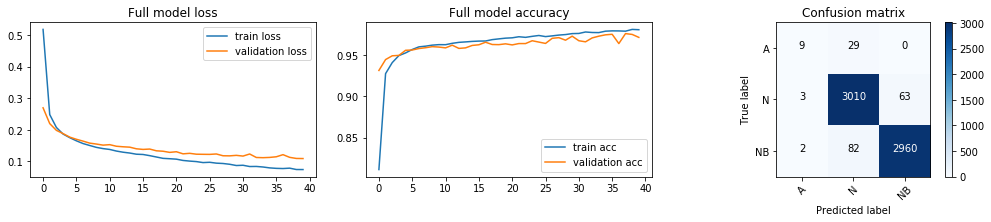

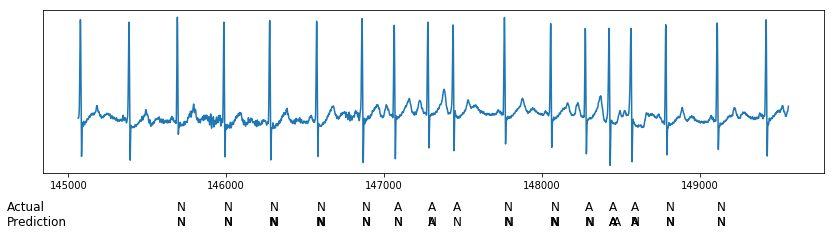

Evaluating model with fc: [1024, 3]


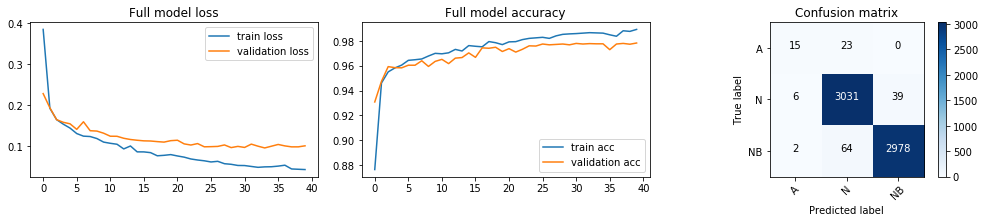

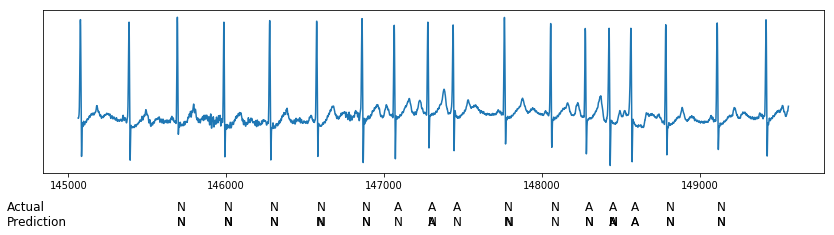

In [219]:
config = {
    'use_conv' : True,
    'ae' : [[(28, 28), [16, 8 , 8], (4,4)],
    'fc' : [ [128,3] ]
}
conv_models = evaluate_ae_models(config,  x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                    ae_epochs=75, full_model_epochs=40, load_prev_ae=False, load_prev_full=False)

### Sequential models

('Running sequential model:', "{'units': [1024, 4], 'dropout': 0.5, 'filters': [16, 32, 64]}")
Successfully loaded weights
Train on 17884 samples, validate on 6853 samples
Epoch 1/5
17884/17884 [==============================] - 33s - loss: 0.0346 - acc: 0.9899 - val_loss: 0.1319 - val_acc: 0.9734
Epoch 2/5
17884/17884 [==============================] - 37s - loss: 0.0269 - acc: 0.9926 - val_loss: 0.1358 - val_acc: 0.9759
Epoch 3/5
17884/17884 [==============================] - 40s - loss: 0.0244 - acc: 0.9926 - val_loss: 0.1594 - val_acc: 0.9679
Epoch 4/5
17884/17884 [==============================] - 41s - loss: 0.0236 - acc: 0.9926 - val_loss: 0.1298 - val_acc: 0.9762
Epoch 5/5
17884/17884 [==============================] - 39s - loss: 0.0223 - acc: 0.9937 - val_loss: 0.1446 - val_acc: 0.9767


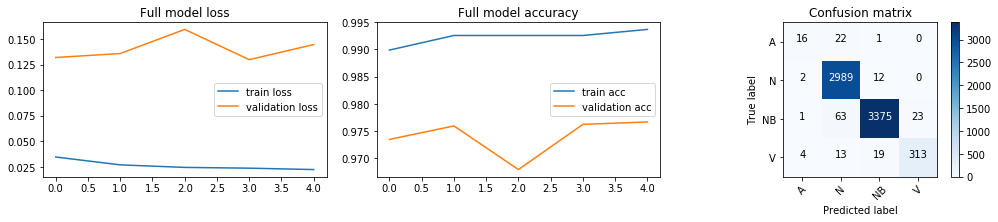

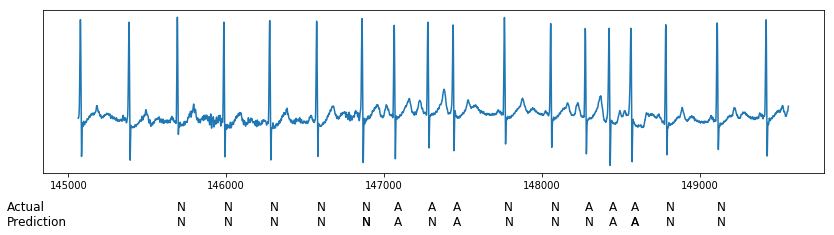

In [43]:
config = [
#     {'filters' : [ 4,  8, 16], 'units': [1024, 3], 'dropout': 0.5},
#     {'filters' : [ 8, 16, 32], 'units': [1024, 3], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5},    
#     {'filters' : [16, 32, 64], 'units': [2048, 3], 'dropout': 0.5},
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                 epochs = 5, load_prev=True)

### Print comparison reports for all architectures

In [213]:
def print_raport(result):
    df  = pd.DataFrame(result)
    display(df[['ae', 'fc', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [21]:
def print_seq_raport(result):
    df  = pd.DataFrame(result)    
    display(df[['filters', 'units', 'dropout', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [221]:
print_raport(nn_models); 

,val_acc,precision,recall,f1_score
0,0.35,0.33,0.34,0.27


,ae,fc,val_acc,precision,recall,f1_score
0,"[784, [], 128]",[3],0.92,0.61,0.62,0.61
1,"[784, [], 128]","[64, 3]",0.95,0.63,0.64,0.63
2,"[784, [], 128]","[128, 3]",0.95,0.63,0.64,0.64
3,"[784, [256, 128], 64]",[3],0.94,0.63,0.63,0.63
4,"[784, [256, 128], 64]","[64, 3]",0.94,0.63,0.63,0.63
5,"[784, [256, 128], 64]","[128, 3]",0.95,0.63,0.64,0.63


In [222]:
print_raport(conv_models)

,ae,fc,val_acc,precision,recall,f1_score
0,"[(28, 28), [16, 8, 8], (4, 4)]",[3],0.94,0.63,0.63,0.63
1,"[(28, 28), [16, 8, 8], (4, 4)]","[64, 3]",0.96,0.74,0.68,0.70
2,"[(28, 28), [16, 8, 8], (4, 4)]","[128, 3]",0.97,0.89,0.72,0.75
3,"[(28, 28), [16, 8, 8], (4, 4)]","[1024, 3]",0.97,0.84,0.73,0.76
4,"[(28, 28), [32, 16, 16], (4, 4)]",[3],0.95,0.64,0.64,0.64
5,"[(28, 28), [32, 16, 16], (4, 4)]","[64, 3]",0.97,0.84,0.72,0.75
6,"[(28, 28), [32, 16, 16], (4, 4)]","[128, 3]",0.97,0.86,0.73,0.76
7,"[(28, 28), [32, 16, 16], (4, 4)]","[1024, 3]",0.98,0.87,0.79,0.82


In [46]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 4]",0.5,0.98,0.9,0.82,0.85


### Train validate on all data

In [32]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 2, load_prev=True)

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5}
Successfully loaded weights


ValueError: Input arrays should have the same number of samples as target arrays. Found 205854 input samples and 308781 target samples.

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 6], 'dropout': 0.5}
Successfully loaded weights
Train on 205854 samples, validate on 86010 samples
Epoch 1/2
205854/205854 [==============================] - 44s - loss: 0.0346 - acc: 0.9922 - val_loss: 0.0912 - val_acc: 0.9824
Epoch 2/2
205854/205854 [==============================] - 46s - loss: 0.0341 - acc: 0.9922 - val_loss: 0.0436 - val_acc: 0.9915


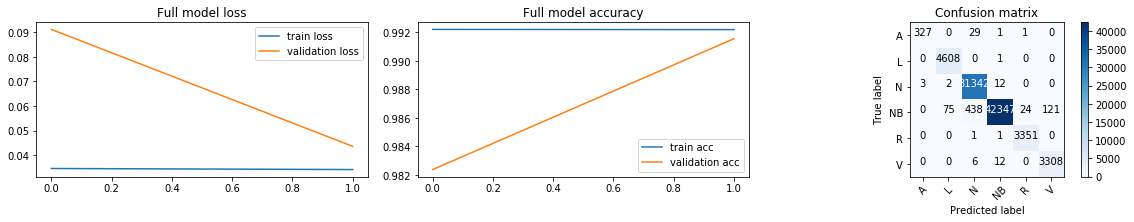

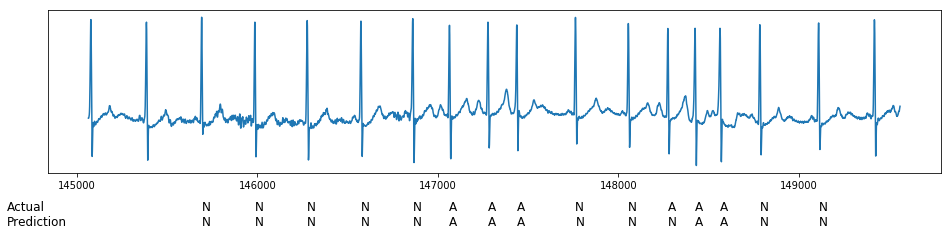

In [43]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 6], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 2, load_prev=True)

In [31]:
# NAV
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 4]",0.5,0.99,0.97,0.97,0.97


In [44]:
# NAVLR
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 6]",0.5,0.99,0.99,0.98,0.98


### Save top model

In [45]:
top_model_path = 'weights/top_model_navlr.h5'

In [49]:
tm = seq_models[0]['model']

In [47]:
tm.save(top_model_path)

In [48]:
lb.classes_

array(['A', 'L', 'N', 'NB', 'R', 'V'],
      dtype='<U2')

### Load top model

In [50]:
tm = seq_models[0]['model']

In [52]:
top_model_path = 'weights/top_model_nav.h5'

In [53]:
tm = load_model(top_model_path)

### Check localization and classification for various patients for the final model

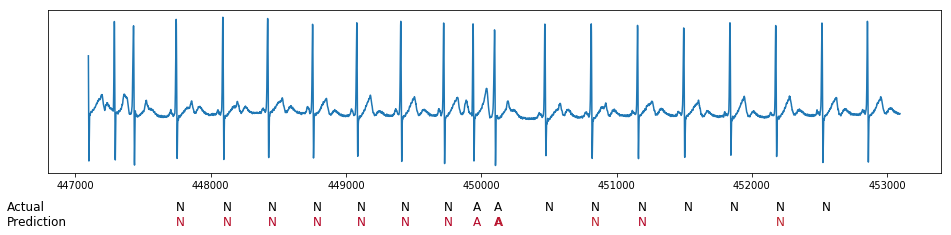

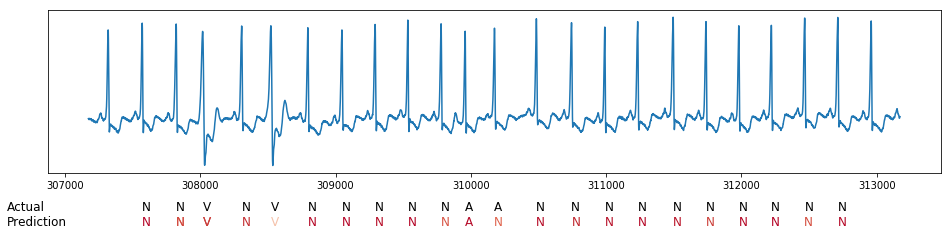

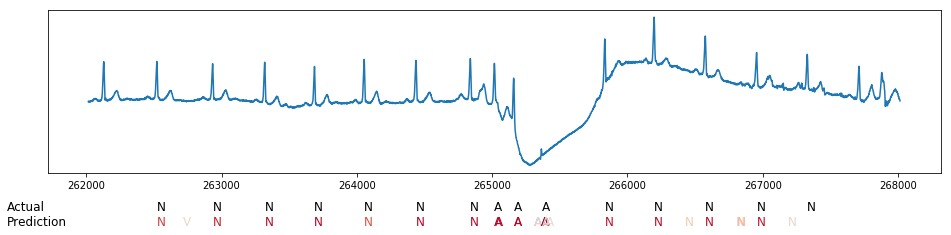

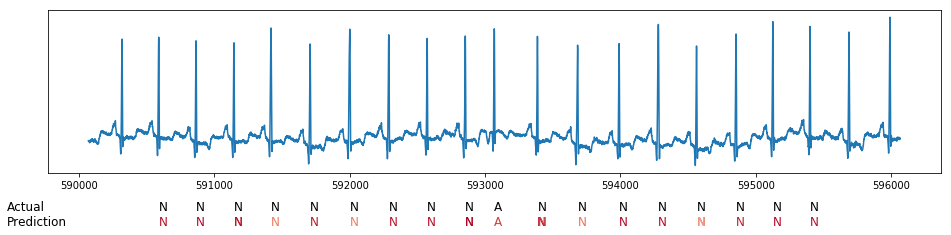

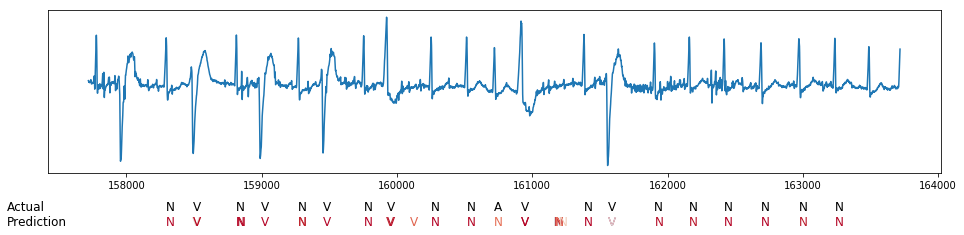

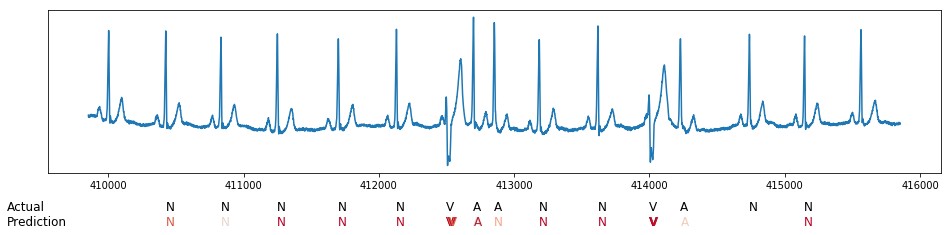

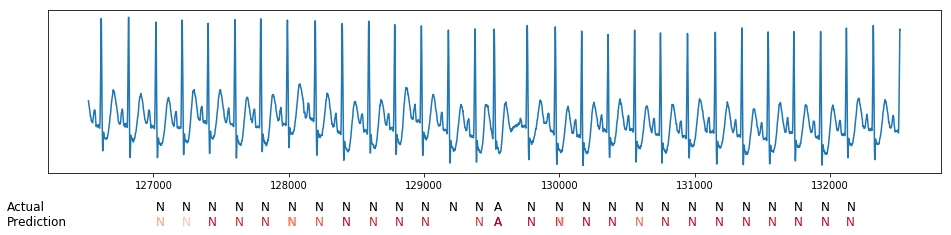

In [53]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['A'])

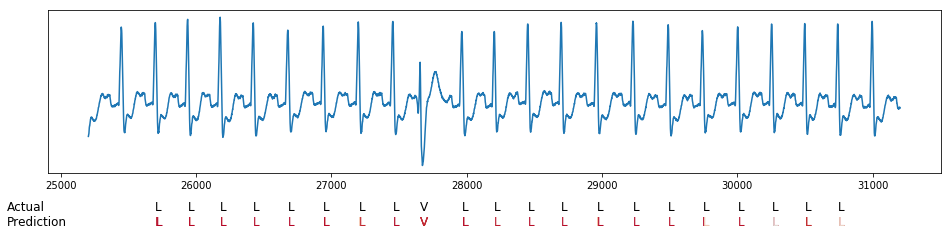

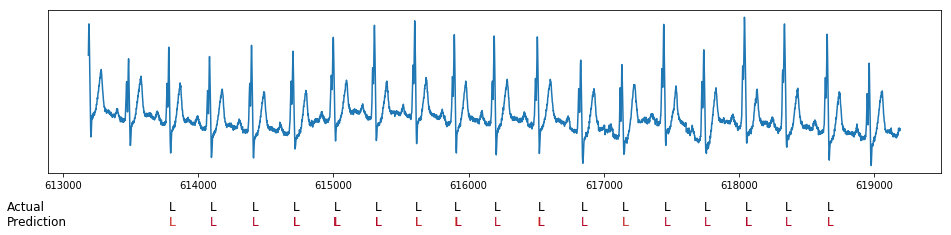

In [63]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['L'])

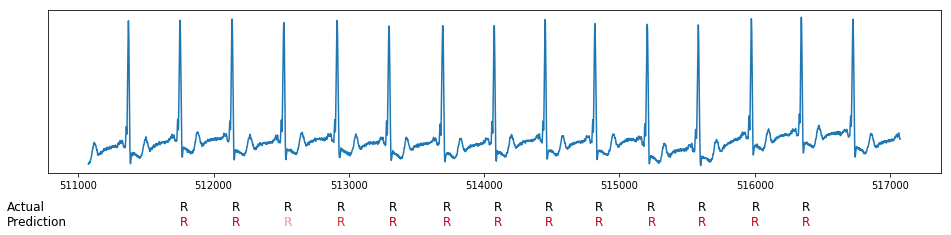

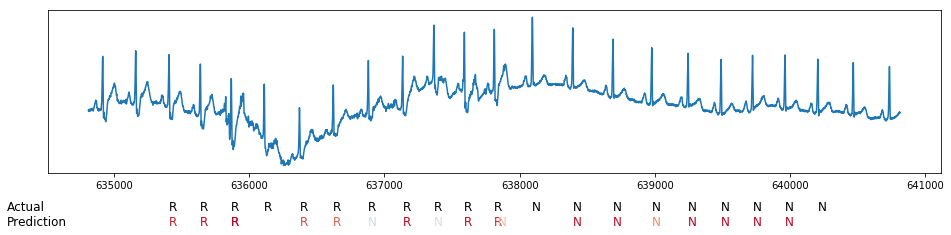

In [62]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['R'])

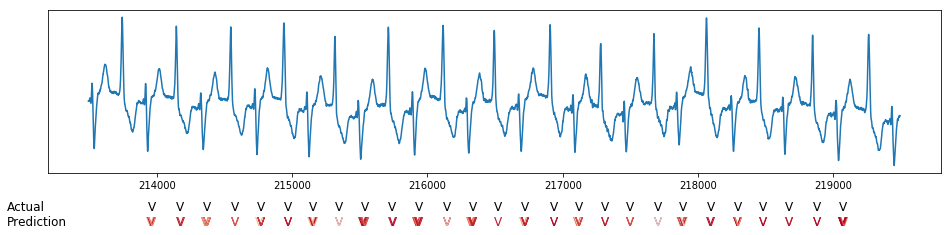

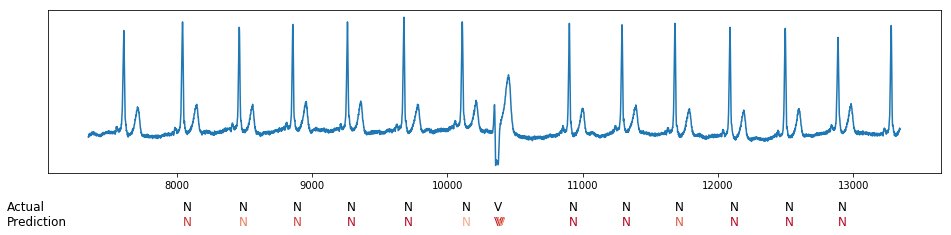

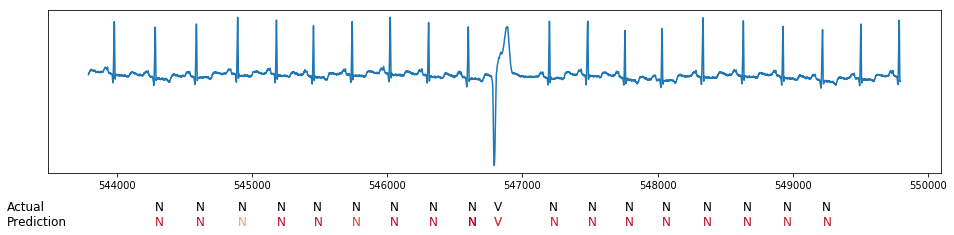

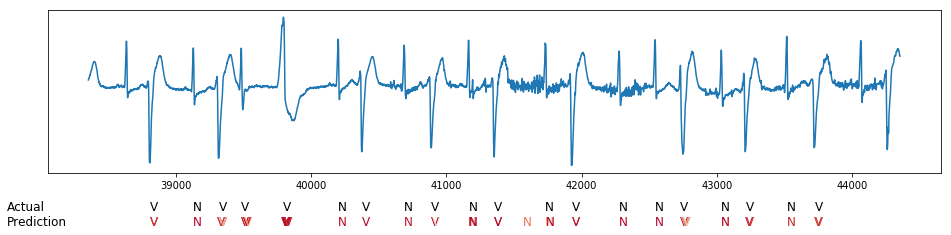

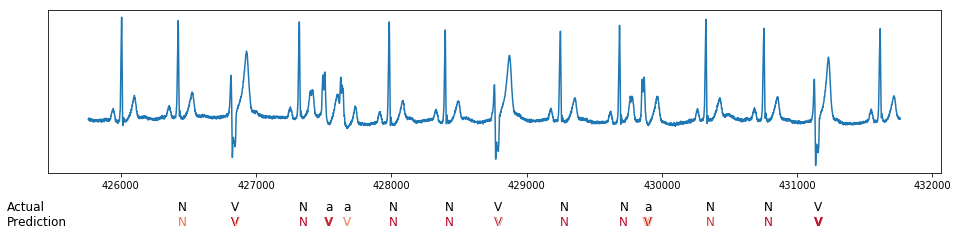

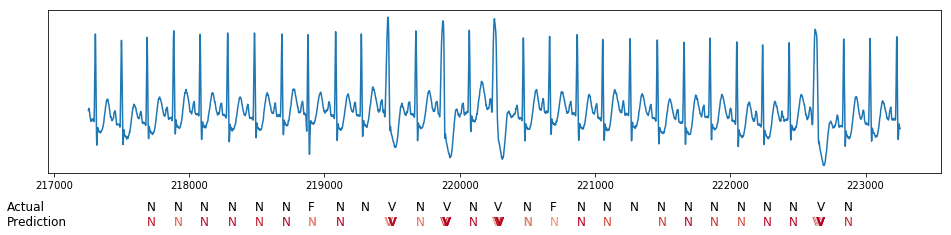

In [64]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['V'])